<img src="../images/kdp_comparison.jpg" width=700 alt="KDP Comparison"></img>

# Specific Differential Phase ($K_{DP}$) retrieval methods comparison

## Overview

Within this notebook, we will cover:

1. How to access Colombian national weather radar network data from AWS
1. How to read and create a multipanel plot
1. How to retrieve and compare three different methods 

## Prerequisites
| Concepts | Importance | Notes |
| --- | --- | --- |
| [Matplotlib Basics](https://foundations.projectpythia.org/core/matplotlib/matplotlib-basics.html) | Required | Basic plotting |
| [Introduction to Cartopy](https://foundations.projectpythia.org/core/cartopy/cartopy.html) | Helpful | Adding projections to your plot |
| [Py-ART Basics](../foundations/pyart-basics) | Required | IO/Visualization |
| [Py-ART Corrections](../foundations/pyart-corrections) | Required | Radar Corrections |
| [Py-ART Example-workflows](../Example-workflows/cacti-data-quality-example) | Required | Dual-polarization variables |
---

## Imports

In [1]:
import xradar as xd
import pyart
import xarray as xr
import numpy as np
import fsspec
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from open_radar_data import DATASETS
import matplotlib.ticker as mticker
import warnings

warnings.filterwarnings("ignore")


## You are using the Python ARM Radar Toolkit (Py-ART), an open source
## library for working with weather radar data. Py-ART is partly
## supported by the U.S. Department of Energy as part of the Atmospheric
## Radiation Measurement (ARM) Climate Research Facility, an Office of
## Science user facility.
##
## If you use this software to prepare a publication, please cite:
##
##     JJ Helmus and SM Collis, JORS 2016, doi: 10.5334/jors.119



## How to access Colombian national weather radar network data from AWS

Let’s start first with Level 2 radar data, which is ground-based radar data collected by the Instituto de Hidrología, Meteorología y Estudios Ambientales (IDEAM).

### Level 2 Data
Level 2 data includes all of the fields in a single file - for example, a file may include:
- Reflectivity
- Velocity
- Differential reflectivity

### Search for data during a Mesoscale Convective System - MCS event (August 9, 2022)

We will access data from the **`radaresideam bucket`**, with the data organized as:

```
s3://s3-radaresideam/l2_data/year/month/date/radar_name/{radar_name[:3].upper()}{year}{month}{date}{hour}{minute}{second}.RAW*
```
 
We can use [fsspec](https://filesystem-spec.readthedocs.io/en/latest/), a tool to work with filesystems in Python, to search through the bucket to find our files!

We start first by setting up our [AWS S3 filesystem](https://aws.amazon.com/s3/)

In [2]:
fs = fsspec.filesystem("s3", anon=True)

Now, we can list files from August 9, 2022, from Carimagua radar (CAR), around 1900 UTC.

In [3]:
files = sorted(fs.glob("s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR22080919*"))
files[:4]

['s3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190003.RAWDSVV',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190315.RAWDSW0',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190401.RAWDSW3',
 's3-radaresideam/l2_data/2022/08/09/Carimagua/CAR220809190505.RAWDSW8']

## Read the data into Py-ART


When reading into Py-ART, we can use the `pyart.io.read_sigmet` or `pyart.io.read` module to read in our data.

In [4]:
radar = pyart.io.read_sigmet(f's3://{files[7]}')

### List the available fields 

In [5]:
sorted(list(radar.fields))

['cross_correlation_ratio',
 'differential_phase',
 'differential_reflectivity',
 'normalized_coherent_power',
 'radar_echo_classification',
 'reflectivity',
 'specific_differential_phase',
 'spectrum_width',
 'total_power',
 'velocity']

### Plot dual-pol variables
Let's plot the radar reflectivity ($Z$), differential reflectivity ($Z_{DR}$), specific differential phase ($K_{DP}$), and cross correlation ratio ($\rho_{HV}$) using a four panel plot.

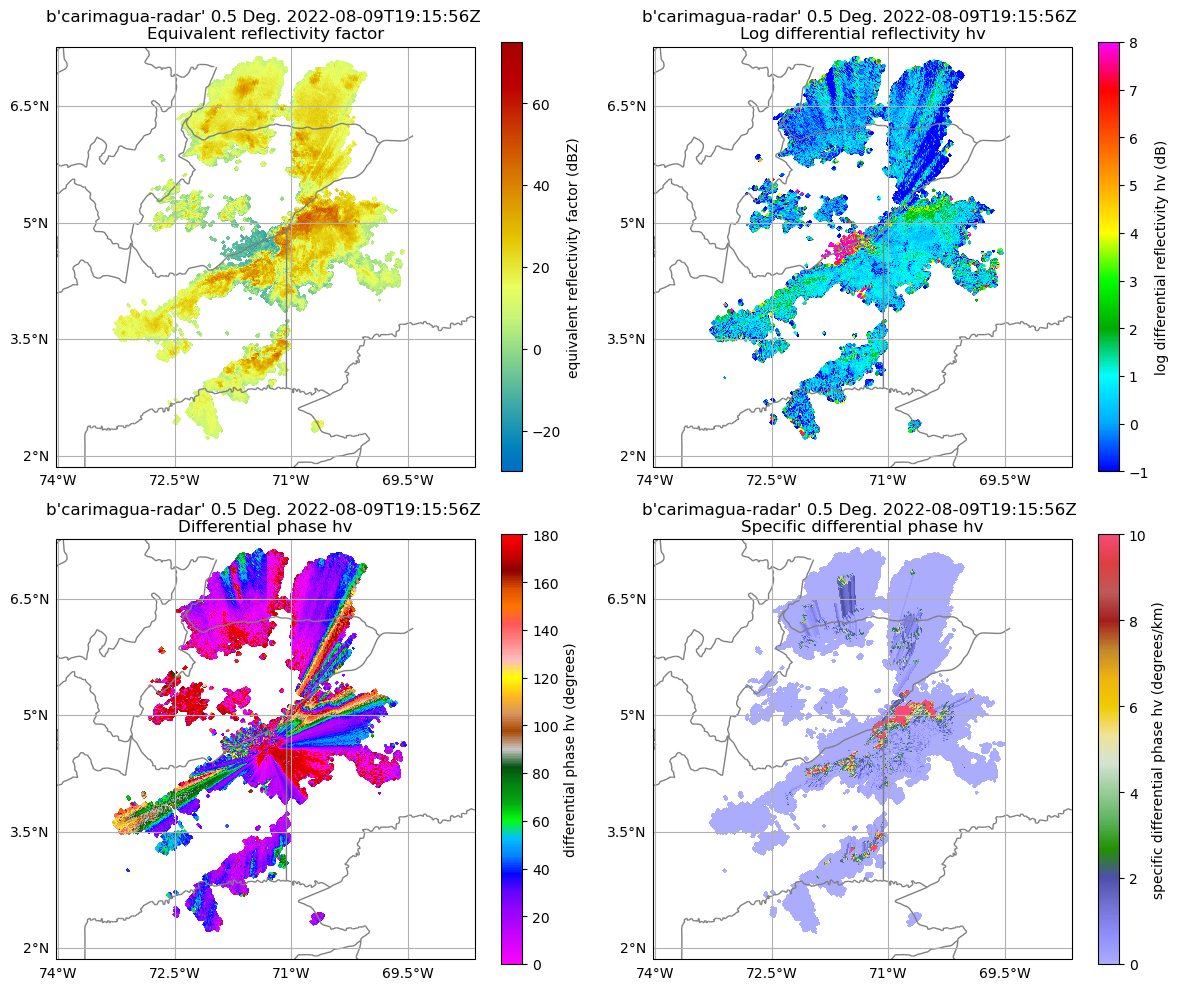

In [6]:
fig = plt.figure(figsize=(12,10))
display = pyart.graph.RadarMapDisplay(radar)
# Extract the latitude and longitude of the radar and use it for the center of the map
lat_center = round(radar.latitude['data'][0], 0)
lon_center = round(radar.longitude['data'][0], 0)


# Determine the ticks
lat_ticks = np.arange(lat_center-3, lat_center+3, 1.5)
lon_ticks = np.arange(lon_center-3, lon_center+3, 1.5)

# Set the projection - in this case, we use a general PlateCarree projection
projection = ccrs.PlateCarree()
ax1 = plt.subplot(221, projection=projection)
display.plot_ppi_map("reflectivity", 0, 
                     resolution='10m', 
                     ax=ax1, 
                     lat_lines=lat_ticks, 
                     lon_lines=lon_ticks)

ax2 = plt.subplot(222, projection=projection)
display.plot_ppi_map("differential_reflectivity", 0, 
                     resolution='10m', 
                     ax=ax2, 
                     lat_lines=lat_ticks, 
                     lon_lines=lon_ticks)

ax3 = plt.subplot(223, projection=projection)
display.plot_ppi_map("differential_phase", 0, 
                     vmin=0, vmax=180,  
                     ax=ax3, resolution='10m', 
                     lat_lines=lat_ticks, 
                     lon_lines=lon_ticks)

ax4 = plt.subplot(224, projection=projection)
display.plot_ppi_map("specific_differential_phase", 0, 
                     vmin=0, vmax=10,  
                     ax=ax4, resolution='10m', 
                     lat_lines=lat_ticks, 
                     lon_lines=lon_ticks)
plt.tight_layout()

We can notice from the previous figure that this is a intense precipitation event in Colombia with reflectivity values up to +55 dBZ, big raindrops ($Z_{DR}$ +3 dB), heavy rainfall rates with $K_{DP}$ +10 dB/km, and multiples foldings in differential phase ($Phi_{DP}$). We can notice negative values in the $Z_{DR}$ panel (differential attenuation) in the north-east side of the radar location. 

## $K_{DP}$ retrieval methods

Although the radar data already contains the specific differential phase ($K_{DP}$), we can use the following alternative methods for comparison:
1. Variational method by Maesaka et al. (2012). 
1. Kalman filter method by Schneebeli and al. (2014)
1. Vulpiani method by Vulpiani et al. (2012)

The `Py-Art` Python package includes all the methods mentioned above. We can access the retrieval methods using `pyart.retrieve.kdp_maesaka`, `pyart.retrieve.kdp_schneebeli`, and `pyart.retrieve.kdp_vulpiani`. The output from all retrieval methods is a tuple with two dictionaries that contain the retrieved $K_{DP}$ as well as the Differential phase ($Phi_{DP}$).

In [7]:
%%time
kdp_maesaka= pyart.retrieve.kdp_maesaka(radar)

CPU times: user 30.6 s, sys: 1min 54s, total: 2min 24s
Wall time: 4.83 s


In [8]:
%%time
kdp_schneebeli = pyart.retrieve.kdp_schneebeli(radar, band='C', parallel=True)

CPU times: user 197 ms, sys: 2.14 s, total: 2.34 s
Wall time: 12.9 s


In [9]:
%%time
kdp_vulpiani = pyart.retrieve.kdp_vulpiani(radar, band='C', parallel=True)

CPU times: user 179 ms, sys: 1.77 s, total: 1.95 s
Wall time: 1.91 s


This is how a dictionary with the retrieve $K_{DP}$ looks like

In [10]:
kdp_vulpiani[0]

{'units': 'degrees/km',
 'standard_name': 'specific_differential_phase_hv',
 'long_name': 'Specific differential phase (KDP)',
 'coordinates': 'elevation azimuth range',
 'data': masked_array(
   data=[[0.0, 0.0, 0.0, ..., --, --, --],
         [0.0, 0.0, 0.0, ..., --, --, --],
         [0.0, 0.0, 0.0, ..., --, --, --],
         ...,
         [0.0, 0.0, 0.0, ..., --, --, --],
         [0.0, 0.0, 0.0, ..., --, --, --],
         [0.0, 0.0, 0.0, ..., --, --, --]],
   mask=[[False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         ...,
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True],
         [False, False, False, ...,  True,  True,  True]],
   fill_value=-9999.0)}

### Add the new retrieved $K_{DP}$ values to the radar object
We can add new fields to our `Py-Art` radar object by using the `pyart.core.Radar.add_field` method as follows

In [11]:
radar.add_field('kdp_maesaka', kdp_maesaka[0])
radar.add_field('phidp_maesaka', kdp_maesaka[1])
radar.add_field('kdp_schneebeli', kdp_schneebeli[0])
radar.add_field('phidp_schneebeli', kdp_schneebeli[1])
radar.add_field('kdp_vulpiani', kdp_vulpiani[0])
radar.add_field('phidp_vulpiani', kdp_vulpiani[1])

### List the new fields/variables

In [12]:
sorted(list(radar.fields))

['cross_correlation_ratio',
 'differential_phase',
 'differential_reflectivity',
 'kdp_maesaka',
 'kdp_schneebeli',
 'kdp_vulpiani',
 'normalized_coherent_power',
 'phidp_maesaka',
 'phidp_schneebeli',
 'phidp_vulpiani',
 'radar_echo_classification',
 'reflectivity',
 'specific_differential_phase',
 'spectrum_width',
 'total_power',
 'velocity']

### Compare default and retrieved $Phi_{DP}$ and $K_{DP}$
We can look at the difference between all the methods using a side-by-side comparison figure

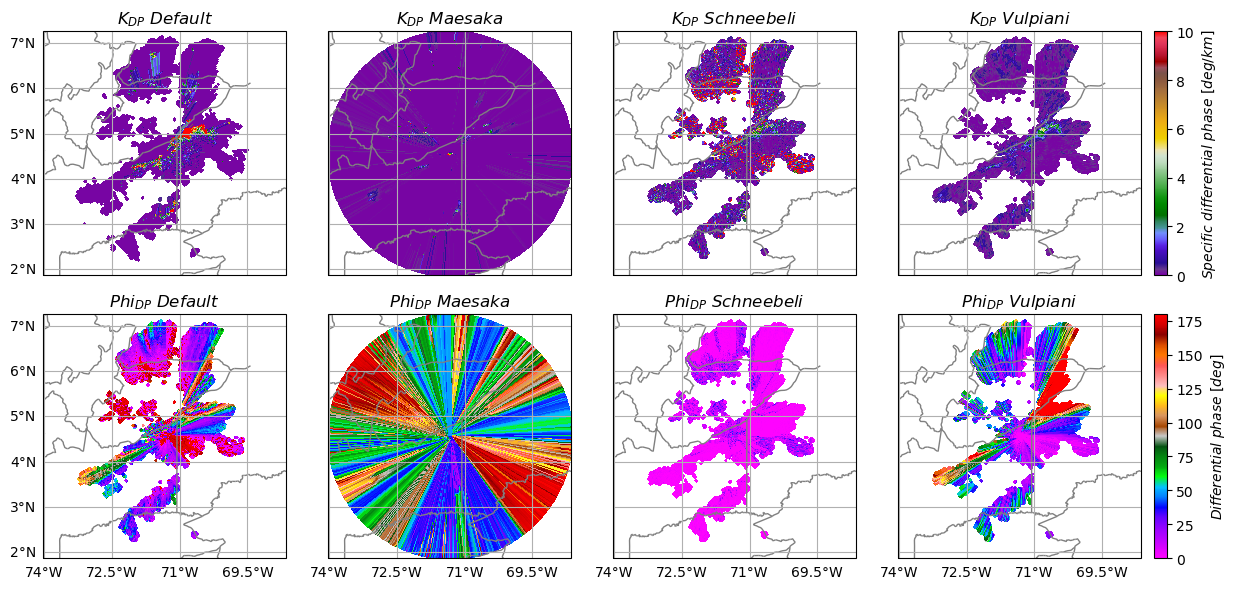

In [13]:
# list of the variables to be plotted
vpol = ['specific_differential_phase', 'kdp_maesaka', 'kdp_schneebeli', 'kdp_vulpiani',
        'differential_phase', 'phidp_maesaka', 'phidp_schneebeli', 'phidp_vulpiani']
# list of cmaps
cmaps = ['pyart_Carbone42'] * 4 + ['pyart_Wild25'] * 4

# list of maximum values
vmaxs = [10] * 4 + [180]  * 4 

# list of tltles
titles = [r"$K_{DP} \ Default$", r"$K_{DP} \ Maesaka$", r"$K_{DP} \ Schneebeli$", r"$K_{DP} \ Vulpiani$", 
          r"$Phi_{DP} \ Default$", r"$Phi_{DP} \ Maesaka$", r"$Phi_{DP} \ Schneebeli$", r"$Phi_{DP} \ Vulpiani$"]

# display object from PyArt
display = pyart.graph.RadarMapDisplay(radar)
fig, axs = plt.subplots(2, 4, figsize=(14,6), subplot_kw={'projection': ccrs.PlateCarree()}, sharey=True, sharex=True)

# Extract the latitude and longitude of the radar and use it for the center of the map
lat_center = round(radar.latitude['data'][0], 0)
lon_center = round(radar.longitude['data'][0], 0)

# Set the projection - in this case, we use a general PlateCarree projection
projection = ccrs.PlateCarree()

# Determine the ticks
lat_ticks = np.arange(lat_center-3, lat_center+3, 1.5)
lon_ticks = np.arange(lon_center-3, lon_center+3, 1.5)

#make axis flatten for iteration
axis = axs.flatten()
# Loop to create all plots
for idx, ax in enumerate(axis):
    display.plot_ppi_map(vpol[idx], 0, resolution='10m', ax=ax, 
                         lat_lines=lat_ticks, 
                         lon_lines=lon_ticks,
                         cmap=cmaps[idx],
                         vmin=0, 
                         vmax=vmaxs[idx],
                         colorbar_flag=False, 
                         title_flag=False, 
                         add_grid_lines=False)
    ax.set_title(titles[idx])
    gl = ax.gridlines(draw_labels=True, rasterized=True)
    gl.xlocator = mticker.FixedLocator(lon_ticks)
    gl.ylabels_right = False
    gl.xlabels_top = False
    gl.ylabels_left = False
    gl.xlabels_bottom = False
    if (idx == 0) | (idx== 4):
        gl.ylabels_left = True
    if  idx>= 4:
        gl.xlabels_bottom = True

fig.tight_layout()
fig.colorbar(display.plots[0], ax=axis[:4], pad=.01, label='$Specific \ differential \  phase  \ [deg/km]$')
fig.colorbar(display.plots[-1], ax=axis[-4:], pad=.01, label='$Differential \ phase  \ [deg]$')
# fig.savefig('../images/kdp_comparison.jpg')

In the top row, we can see the Specific Differential Phase ($K_{DP}$), and in the bottom row, the Differential Phase ($Phi_{DP}$). We can notice that the default $K_{DP}$ shows values +10 deg/km, which we think is too high. On the other hand, Maesake's and Scneebeli's methods' output suggests that they are probably not performing well. However, the Vulpiani method performs better since we can observe more realistic values on $K_{DP}$ and $Phi_{DP}$.  

<div class="admonition alert alert-warning">
    <p class="admonition-title" style="font-weight:bold">Warning</p>
    This notebook is intended to be demonstrative; therefore, we can not make any conclusions regarding the methods we tested.
</div>

---
## Summary
Within this example, we walked through how to access Colombian radar data from IDEAM, plot a quick look of the data, and compare the the specific differential phase using the default and three different methods!

### What's Next?
We will showcase other data workflow examples, including field campaigns in other regions and data access methods from other data centers.

## Resources and References
* [IDEAM radar data](https://registry.opendata.aws/ideam-radares/)
* Py-ART:
    - Helmus, J.J. & Collis, S.M., (2016). The Python ARM Radar Toolkit (Py-ART), a Library for Working with Weather Radar Data in the Python Programming Language. Journal of Open Research Software. 4(1), p.e25. DOI: http://doi.org/10.5334/jors.119
* ACT:
    - Adam Theisen, Ken Kehoe, Zach Sherman, Bobby Jackson, Alyssa Sockol, Corey Godine, Max Grover, Jason Hemedinger, Jenni Kyrouac, Maxwell Levin, Michael Giansiracusa (2022). The Atmospheric Data Community Toolkit (ACT). Zenodo. DOI: https://doi.org/10.5281/zenodo.6712343
* Maesaka, T., Iwanami, K. and Maki, M., 2012: Non-negative KDP Estimation by Monotone Increasing PHIDP Assumption below Melting Layer. The Seventh European Conference on Radar in Meteorology and Hydrology.
* Schneebeli, M., Grazioli, J., and Berne, A., 2014: Improved Estimation of the Specific Differential Phase SHIFT Using a Compilation of Kalman Filter Ensembles, IEEE T. Geosci. Remote Sens., 52, 5137-5149, https://doi:10.1109/TGRS.2013.2287017
* Gianfranco Vulpiani, Mario Montopoli, Luca Delli Passeri, Antonio G. Gioia, Pietro Giordano, and Frank S. Marzano, 2012: On the Use of Dual-Polarized C-Band Radar for Operational Rainfall Retrieval in Mountainous Areas. J. Appl. Meteor. Climatol., 51, 405-425, doi: https://10.1175/JAMC-D-10-05024.1.